# Using the MaterialMixture

In the [first tutorial](./simple_fitting.html), we looked at a straight forward example of a polymer film at the solid/liquid interface. 
To analyse this data, we constructed a model with two layers, one SiO<sub>2</sub> and one of the polymer film, and when the analysis was performed, the scattering length density of the polymer film was allowed to vary to find an optimum value. 
However, it is likely that this scattering length density is in fact a compound value arising from the mixture of the polymer with some D<sub>2</sub>O intercalated. 
Therefore, if, for example, the surface covereage of the polymer was known, it may be possible to determine the scattering length density alone. 
Of course, this could be calculated from the optimal scattering length density for the film, but it is more intuitive to include this in our modelling approach. 
Here, we will show how to use the `MaterialMixture` [type](./material_library.html#materialmixture) to perform this analysis. 

First configure matplotlib to place figures in notebook and import needed modules

In [2]:
%matplotlib inline

import numpy as np
import scipp as sc
import EasyReflectometry
import refnx
from EasyReflectometry.data import load
from EasyReflectometry.sample import Layer, Structure
from EasyReflectometry.sample.material import Material, MaterialMixture
from EasyReflectometry.sample.item import MultiLayer
from EasyReflectometry.experiment.model import Model
from EasyReflectometry.interface import InterfaceFactory as Interface
from EasyReflectometry.fitting import Fitter
from EasyReflectometry.plot import plot

Showing the version of specific softare for reproducibility

In [3]:
print(f'numpy: {np.__version__}')
print(f'scipp: {sc.__version__}')
print(f'EasyReflectometry: {EasyReflectometry.__version__}')
print(f'refnx: {refnx.__version__}')

numpy: 1.26.3
scipp: 23.08.0
EasyReflectometry: 0.0.2
refnx: 0.1.41


For information about the data being read in and the details of the model see [the previous tutorial](./simple_fitting.html). 
We will gloss over these details here. 

In [4]:
data = load('_static/example.ort')

c:\Users\andpe\miniconda3\envs\reflectometry311\Lib\site-packages\orsopy\fileio\base.py:277: RuntimeWarning: Has to be one of ('neutron', 'x-ray') got neutrons
  warnings.warn(


## Constructing the model

Previously the model consisted of four materials, we will construct those again here. 

In [5]:
si = Material.from_pars(2.07, 0, 'Si')
sio2 = Material.from_pars(3.47, 0, 'SiO2')
film = Material.from_pars(2.0, 0, 'Film')
d2o = Material.from_pars(6.36, 0, 'D2O')

However, now we will construct a component object (for type `MaterialMixture`), based on the knowledge that there is a 75 % surface coverage of the silicon block by the polymer film. 
Note that this object takes the two materials and then the fractional amount of the second material in the first.

In [6]:
solvated_film = MaterialMixture.from_pars(film, d2o, 0.25, name='Solvated Film')

So for the `solvated_film` object, the scattering length density is calculated as,

$$ \rho_{\mathrm{solv film}} = (1-\phi)\rho_{\mathrm{film}} + \phi\rho_{\mathrm{D}_2\mathrm{O}}, $$

where the scattering length densities are given with $\rho$ and the solvation fraction with $\phi$. 
This means that when we investigate the `solvated_film` object, the scattering length density will be 3.09e-6 Å<sup>-2</sup>

In [7]:
solvated_film

Solvated Film:
  fraction: 0.25
  sld: 3.090e-6 1 / angstrom ** 2
  isld: 0.000e-6 1 / angstrom ** 2
  material1:
    Film:
      sld: 2.000e-6 1 / angstrom ** 2
      isld: 0.000e-6 1 / angstrom ** 2
  material2:
    D2O:
      sld: 6.360e-6 1 / angstrom ** 2
      isld: 0.000e-6 1 / angstrom ** 2

Now, we can construct our layers, structure and model. 

In [8]:
si_layer = Layer.from_pars(si, 0, 0, 'Si layer')
sio2_layer = Layer.from_pars(sio2, 30, 3, 'SiO2 layer')
solvated_film_layer = Layer.from_pars(solvated_film, 250, 3, 'Film Layer')
superphase = Layer.from_pars(d2o, 0, 3, 'D2O Subphase')

subphase = MultiLayer.from_pars([si_layer, sio2_layer], name='Si/SiO2 Superphase')
structure = Structure.from_pars(subphase, solvated_film_layer, superphase, name='Film Structure')
model = Model.from_pars(structure, 1, 1e-6, 0.02, 'Film Model')

## Setting varying parameters

Previously, the scattering length density of the `film_layer` was allowed to vary (in addition to other parameters). 
This time, the scattering length density will for the `film` be varied, leading to a change in the `solvated_film_layer` scattering length density. 
We show this in the four code cells below. 

In [9]:
film.sld.value = 2.0

In [10]:
print(solvated_film_layer.material.sld)

<Parameter 'sld': 3.09+/-0 1/Å² (fixed), bounds=[-inf:inf]>


In [11]:
film.sld.value = 2.5

In [12]:
print(solvated_film_layer.material.sld)

<Parameter 'sld': 3.465+/-0 1/Å² (fixed), bounds=[-inf:inf]>


The parameter bounds are then set as follows. 

In [13]:
# Thicknesses
sio2_layer.thickness.bounds = (15, 50)
solvated_film_layer.thickness.bounds = (200, 300)
# Roughnesses
sio2_layer.roughness.bounds = (1, 15)
solvated_film_layer.roughness.bounds = (1, 15)
superphase.roughness.bounds = (1, 15)
# Scattering length density
film.sld.bounds = (0.1, 3)
# Background
model.background.bounds = (1e-8, 1e-5)
# Scale
model.scale.bounds = (0.5, 1.5)

## Perform the fitting

Having constructed the model and set the relevant varying parameters, we run the analysis (using the default [refnx engine](https://refnx.readthedocs.io/)). 

In [14]:
interface = Interface()
model.interface = interface
fitter = Fitter(model)
analysed = fitter.fit(data)

The model fits well to the data.

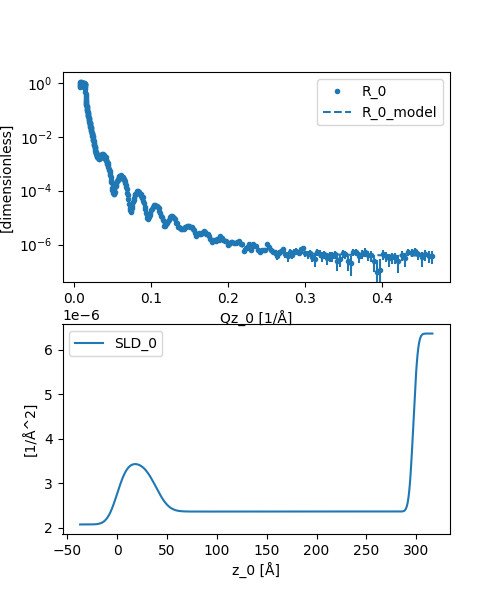

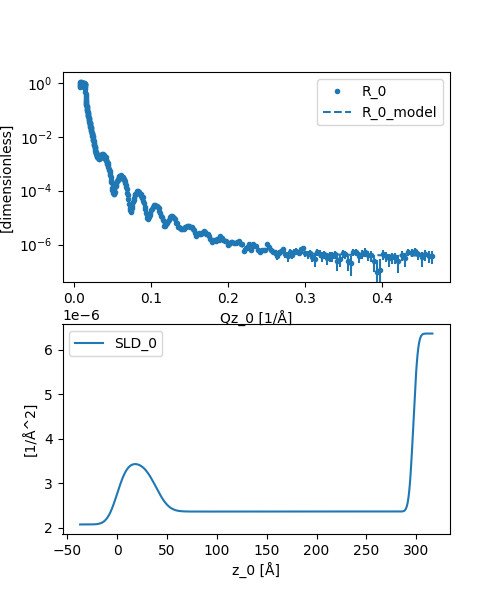

In [16]:
plot(analysed)

We can probe the `MaterialMixture` object to investigate the scattering length density of the polymer film alone.

In [ ]:
solvated_film

The total scattering length density is 2.360e-6 Å<sup>-2</sup> (which is the same as the result from the [previous tutorial](./simple_fitting.html)).
We can see that for a surface coverage of the polymer of 75 % the scattering length density for the polymer film alone is 1.026e-6 Å<sup>-2</sup>.